In [3]:
import os
from tqdm.notebook import tqdm
from deepmusic import MusicRepr, Constants
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import pickle
import seaborn as sns

tqdm.pandas()

# LMD-matched dataset

In [3]:
const = Constants(unit=4, num_tempo_bins=20, num_velocity_bins=20)
path = '/home/soroosh/data/MIDI/lmd_processed/'
files = list(filter(lambda x: x.endswith('.mid'), os.listdir(path)))
len(files)

22945

In [54]:
def process_file(file):
    seq = MusicRepr.from_file(path + file, const=const)
    tracks = seq.separate_tracks()
    ent = {'file' : file, 'n_bar': seq.get_bar_count()}
    for inst in const.instruments:
        if inst in tracks:
            ent[inst] = len(tracks[inst])
        else:
            ent[inst] = 0
    return ent
    
res = Parallel(n_jobs=20)(delayed(process_file)(file) for file in tqdm(files))

In [174]:
df = pd.DataFrame(res)
df = df.sort_values('n_bar').reset_index(drop=True)
df.head()

,file,n_bar,piano,percussion,organ,guitar,bass,strings,ensemble,brass,...,pipe,synth-lead,synth-pad,synth-effects,ethnic,percussive,sound-effects,drums,genre,style
0,9ceb6e6904becc8c2a75fe0c3a37657f.mid,453,0,0,0,1247,6407,1070,4331,2475,...,790,0,0,0,0,0,0,0,,
1,22a6ad62aebeb0612700f64d02dc18ec.mid,443,0,0,0,0,0,1178,11786,1540,...,1734,0,0,0,0,0,0,0,,
2,4fb43d0e8e8d263a5c97a797d8343a08.mid,405,7954,5133,0,4696,3553,0,0,0,...,0,0,4383,0,0,0,0,9507,,
3,a595d0ca98ca67de51306436cf23efae.mid,401,0,0,0,0,0,2648,10026,1090,...,1626,0,0,0,0,0,0,0,,
4,934b2b590e68fb5c6b7ea99b8292af51.mid,400,0,0,0,0,0,0,11299,1119,...,1610,0,0,0,0,0,0,0,,


In [16]:
df.to_csv('lmd_data.csv', index=False)

In [176]:
# f = open('/home/soroosh/data/MIDI/LMD-Matched/msd-MAGD-genreAssignment.cls')
# s = f.read().strip().split('\n')
# f.close()
# print(len(s))

# genre_map = {}
# for l in s:
#     a,b = l.split('\t')
#     genre_map[a] = b
    
# f = open('/home/soroosh/data/MIDI/LMD-Matched/msd-MASD-styleAssignment.cls')
# s = f.read().strip().split('\n')
# f.close()
# print(len(s))

# style_map = {}
# for l in s:
#     a,b = l.split('\t')
#     style_map[a] = b
    
# f = open('/home/soroosh/data/MIDI/LMD-Matched/file_paths.txt')
# s = f.read().strip().split('\n')
# f.close()
# print(len(s))

# hash_map = {}
# for l in s:
#     a,b = l.split('/')[-2:]
#     hash_map[b] = a
    
# print(len(set(style_map).intersection(set(genre_map))))

In [177]:
# df['genre'] = df['file'].apply(lambda x: genre_map[hash_map[x]] if hash_map[x] in genre_map else '')
# df['style'] = df['file'].apply(lambda x: style_map[hash_map[x]] if hash_map[x] in style_map else '')

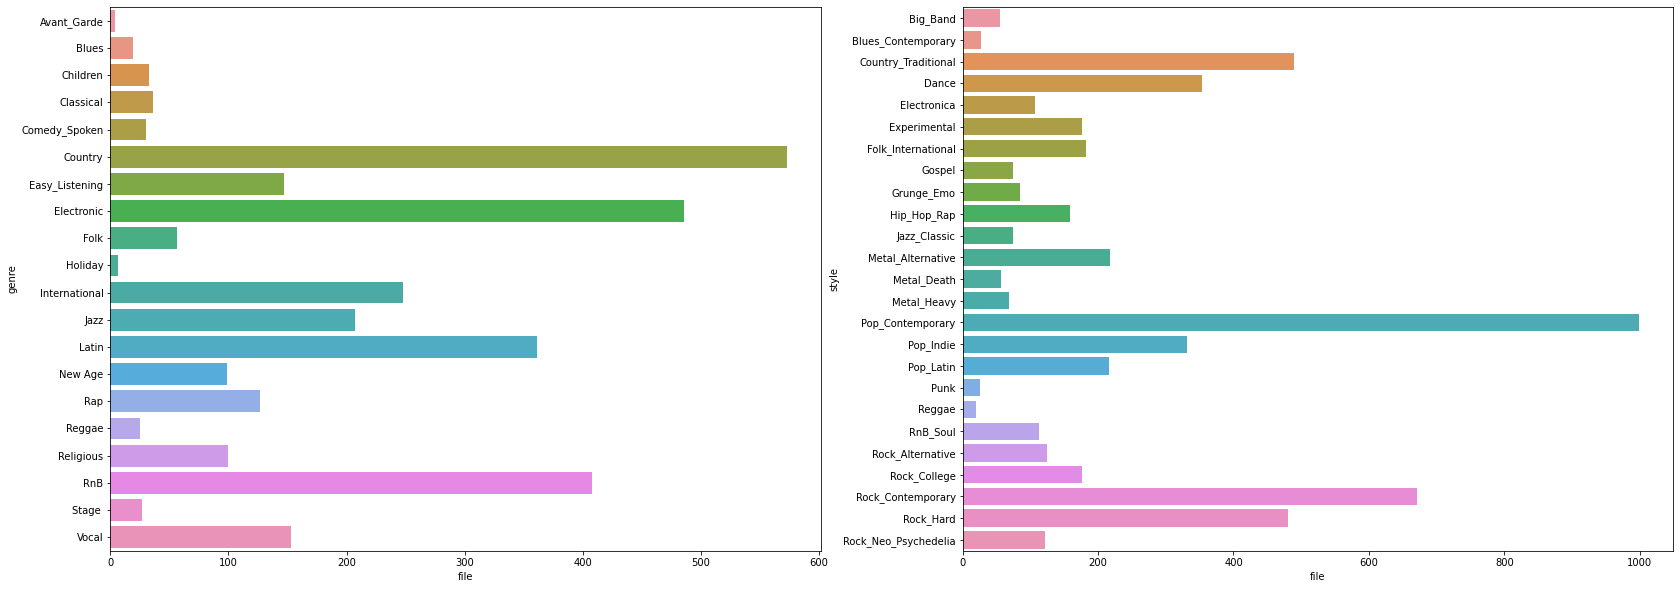

In [36]:
plt.figure(figsize=(28,10))
plt.subplot(1,2,1)
data = df[~df.genre.isin(['-', 'Pop_Rock'])].groupby('genre').count()
sns.barplot(y=data.index, x=data.file)
plt.subplot(1,2,2)
data = df[df['style'] != '-'].groupby('style').count()
sns.barplot(y=data.index, x=data.file)
plt.show()

## customize for training

In [39]:
df2 = df[(df.piano > 0) & (df.guitar > 0) & (df.drums > 0)]
df2['sum_events'] = df2.progress_apply(lambda x: x['piano'] + x['guitar'] + x['drums'], axis=1)
df2['piano_frac'] = df2.progress_apply(lambda x: x['piano']/ x['sum_events'], axis=1)
df2['guitar_frac'] = df2.progress_apply(lambda x: x['guitar']/ x['sum_events'], axis=1)
df2['drums_frac'] = df2.progress_apply(lambda x: x['drums']/ x['sum_events'], axis=1)
df2['avg_event_per_bar'] = df2.progress_apply(lambda x: x['sum_events']/x['n_bar'], axis=1)
print(df2.shape)
df2.head()

  0%|          | 0/11131 [00:00<?, ?it/s]

  0%|          | 0/11131 [00:00<?, ?it/s]

  0%|          | 0/11131 [00:00<?, ?it/s]

  0%|          | 0/11131 [00:00<?, ?it/s]

  0%|          | 0/11131 [00:00<?, ?it/s]

(11131, 26)


,file,n_bar,piano,percussion,organ,guitar,bass,strings,ensemble,brass,...,percussive,sound-effects,drums,genre,style,sum_events,piano_frac,guitar_frac,drums_frac,avg_event_per_bar
2,4fb43d0e8e8d263a5c97a797d8343a08.mid,405,7954,5133,0,4696,3553,0,0,0,...,0,0,9507,-,-,22157,0.358984,0.211942,0.429074,54.708642
20,5dd4427d17c9f72d41231ac40337f30b.mid,306,1691,0,0,897,810,0,0,0,...,0,0,1997,Pop_Rock,Pop_Latin,4585,0.368811,0.195638,0.435551,14.983660
23,c301629e57f9a052b783601de8c43d45.mid,304,3077,1173,739,3176,2074,0,1017,604,...,0,0,8252,-,-,14505,0.212134,0.218959,0.568907,47.713816
29,9b00e3e07949ddb99638f4cf0c0a914c.mid,292,697,0,1696,3243,1788,0,695,0,...,0,301,4786,-,-,8726,0.079876,0.371648,0.548476,29.883562
33,1a2edb832812beeaab257acf69e2c7f1.mid,291,1830,0,0,11698,1779,0,292,0,...,0,317,4970,-,-,18498,0.098930,0.632393,0.268678,63.567010


In [49]:
df3 = df2[df2['genre'] != '-']
print(df3.shape)

(3908, 26)


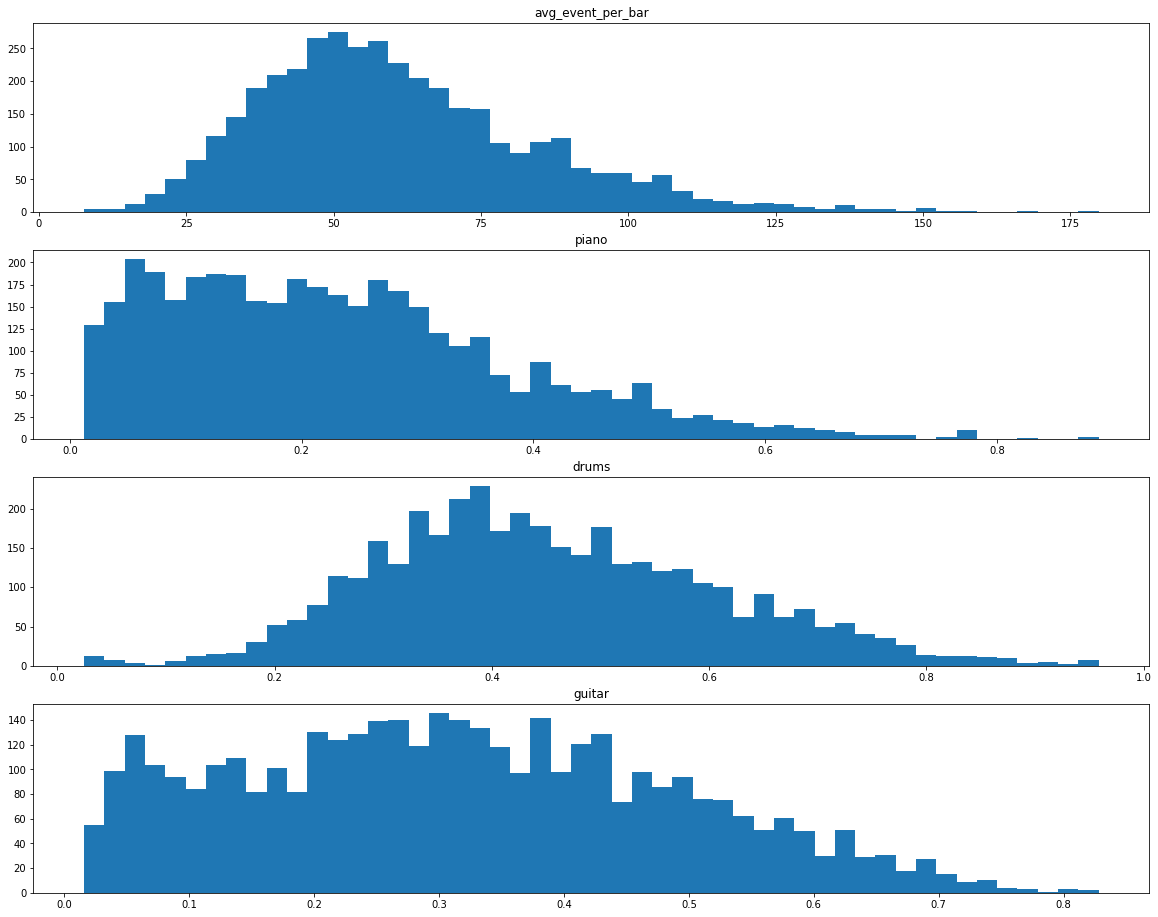

In [50]:
plt.figure(figsize=(20,16))
plt.subplot(4,1,1)
plt.title('avg_event_per_bar')
plt.hist(df3.avg_event_per_bar, 50)
plt.subplot(4,1,2)
plt.title('piano')
plt.hist(df3.piano_frac, 50)
plt.subplot(4,1,3)
plt.title('drums')
plt.hist(df3.drums_frac, 50)
plt.subplot(4,1,4)
plt.title('guitar')
plt.hist(df3.guitar_frac, 50)
plt.show()

In [71]:
df4 = df3[df3.drums_frac > 0.2]
df4 = df4[~df4.genre.isin([
    'Avant_Garde', 'Blues', 'Children', 'Classical', 'Stage ', 
    'New Age', 'Reggae', 'Comedy_Spoken', 'Pop_Rock',
])]
# df3 = df3[['file', 'n_bar', 'piano', 'guitar', 'drums']]
print(df4.shape)
df4.head()

(1426, 26)


,file,n_bar,piano,percussion,organ,guitar,bass,strings,ensemble,brass,...,percussive,sound-effects,drums,genre,style,sum_events,piano_frac,guitar_frac,drums_frac,avg_event_per_bar
37,2c551146413a5c88d2ade4d311018d1a.mid,285,4435,0,0,390,0,547,798,485,...,0,0,5708,Jazz,Folk_International,10533,0.421058,0.037026,0.541916,36.957895
62,a5e2e7ce6c7c34d3741b7c98b9b4b99a.mid,269,760,0,0,680,1468,0,508,1780,...,0,273,3769,Jazz,Jazz_Classic,5209,0.145901,0.130543,0.723555,19.364312
118,24ad7c135774118dc88eb7edfc3f9414.mid,243,3587,0,394,411,2898,0,2435,0,...,246,245,5195,Electronic,Dance,9193,0.390188,0.044708,0.565104,37.831276
159,eeda5bf16ad386789ec1f7ce06737d39.mid,234,4249,1615,0,9042,1754,0,1496,0,...,0,0,14379,Electronic,Dance,27670,0.153560,0.326780,0.519660,118.247863
182,337577a132a7253b427d767350d44554.mid,229,2065,0,0,604,1330,1135,2596,495,...,0,630,3210,RnB,Pop_Contemporary,5879,0.351250,0.102739,0.546011,25.672489


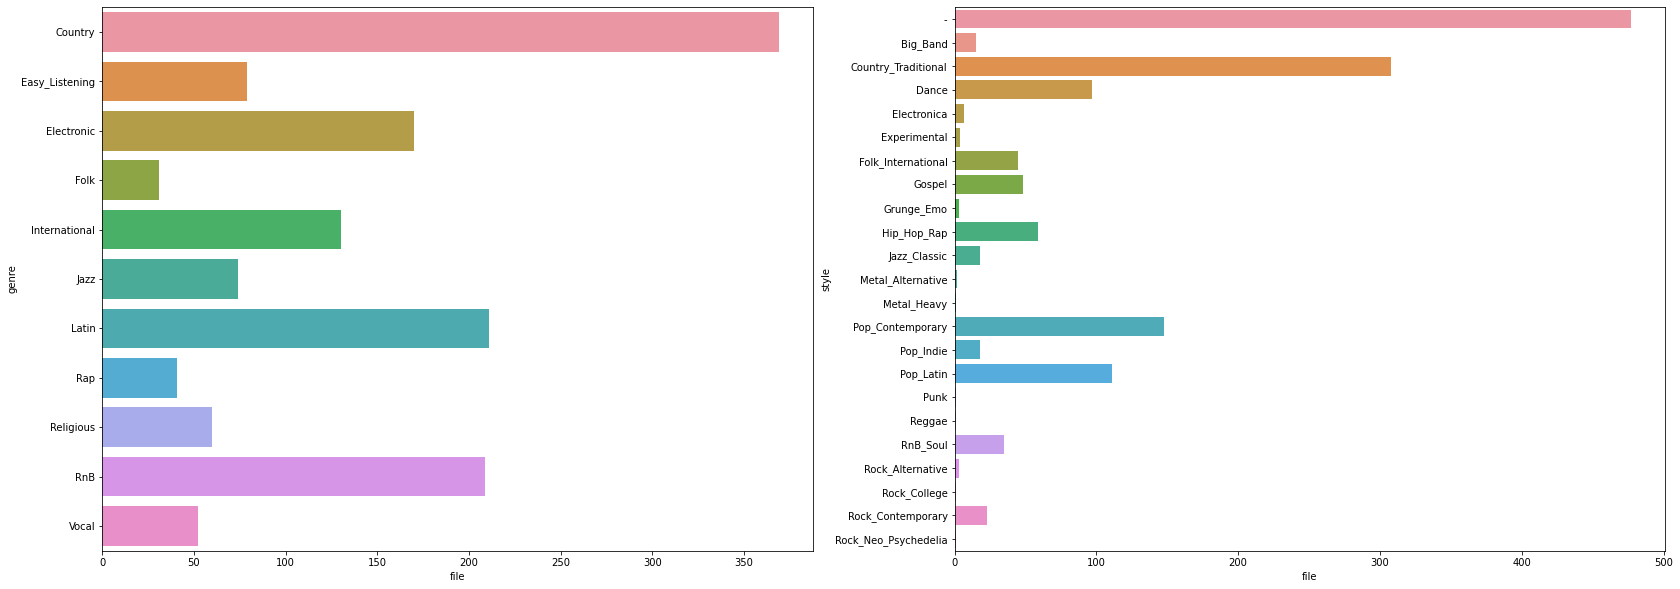

In [72]:
plt.figure(figsize=(28,10))
plt.subplot(1,2,1)
data = df4.groupby('genre').count()
sns.barplot(y=data.index, x=data.file)
plt.subplot(1,2,2)
data = df4.groupby('style').count()
sns.barplot(y=data.index, x=data.file)
plt.show()

In [73]:
files = df4.file.to_list()
pickle.dump(files, open('files.pkl', 'wb'))

# e-gmd dataset